## First, get the data into a useful format

In [29]:
import glob
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LogisticRegression
!pip install wget
import wget
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import copy
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import brier_score_loss
from sklearn import svm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set your directory path
#YOUR_DIRECTORY = '/content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 6/Project 6/'  # Chu-Chun
YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/Project_6/' # Jeff

In [25]:
# Read in datafile
features = pd.read_csv(YOUR_DIRECTORY + 'SouthAmericanRainfall_MJOIndices_v1.csv', index_col = 'Unnamed: 0')
features.columns.name = 'Date'
features = features.dropna()
features.index = pd.to_datetime(features.index)

# Add year, month, day as features
features['Year'] = features.index.year
features['Month'] = features.index.month
features['Day'] = features.index.day
features

Date,BahiaBlanca_Rainfall,MJOPhase_OLR,MJOLongitude_OLR,MJOAmplitude_OLR,MJOPhase_Chi200,MJOLongitude_Chi200,MJOAmplitude_Chi200,ERA5_Soil_Moisture_Lev1,ERA5_Soil_Moisture_Lev2,Year,Month,Day
1980-01-01,0.0,5,148.6,0.6049,5,175.4,0.5459,0.209384,0.205773,1980,1,1
1980-01-02,0.0,5,164.0,0.6069,6,187.0,0.7355,0.181627,0.198426,1980,1,2
1980-01-03,0.0,5,176.0,0.5613,6,198.4,0.6891,0.175117,0.192707,1980,1,3
1980-01-04,0.0,6,185.2,0.6842,6,191.3,0.7448,0.150012,0.179462,1980,1,4
1980-01-05,18.0,6,199.9,0.8435,6,215.7,0.8425,0.191845,0.175685,1980,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,2.0,4,116.2,0.5752,5,139.0,1.0510,0.235895,0.146751,2019,12,20
2019-12-21,0.0,5,136.8,0.5292,5,148.3,1.3558,0.205727,0.149838,2019,12,21
2019-12-28,0.0,7,247.8,0.8633,7,252.5,0.9382,0.127302,0.142428,2019,12,28
2019-12-30,5.1,8,277.6,0.6520,8,291.6,0.7442,0.162332,0.140790,2019,12,30


In [26]:
features.describe()

Date,BahiaBlanca_Rainfall,MJOPhase_OLR,MJOLongitude_OLR,MJOAmplitude_OLR,MJOPhase_Chi200,MJOLongitude_Chi200,MJOAmplitude_Chi200,ERA5_Soil_Moisture_Lev1,ERA5_Soil_Moisture_Lev2,Year,Month,Day
count,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000,6972.000000
mean,2.870554,4.441193,179.069148,1.236037,4.523810,177.512177,1.248430,0.217603,0.208701,1997.337780,6.581756,15.727625
std,9.056040,2.286059,104.737439,0.675765,2.282107,103.815770,0.659275,0.058850,0.050359,10.714869,3.500935,8.804722
min,0.000000,1.000000,0.000000,0.017200,1.000000,0.100000,0.008200,0.100368,0.115006,1980.000000,1.000000,1.000000
25%,0.000000,2.000000,89.775000,0.716800,3.000000,87.075000,0.751300,0.167342,0.168814,1989.000000,3.000000,8.000000
50%,0.000000,4.000000,175.250000,1.144300,4.000000,177.100000,1.174900,0.217739,0.203565,1996.000000,7.000000,16.000000
75%,1.000000,6.000000,269.925000,1.662525,7.000000,267.400000,1.656475,0.263776,0.244602,2005.000000,10.000000,23.000000
max,142.000000,8.000000,359.900000,3.995100,8.000000,360.000000,3.888200,0.357575,0.355990,2019.000000,12.000000,31.000000


## Model Features and Labels

In [0]:
# Separating columns into features and labels, then performing randomized splitting into training (70%) and testing (30%) datasets
labels = features['BahiaBlanca_Rainfall'].to_numpy() # Y
feats = features.drop(columns = ['BahiaBlanca_Rainfall']).to_numpy() # X
train_features, test_features, train_labels, test_labels = train_test_split(feats, labels, test_size = 0.3, random_state = 42)

# Save feature list for variable importance later on
featlist = features.drop(columns = ['BahiaBlanca_Rainfall'])
feature_list = list(featlist.columns)

## Function to create climatological probability for Brier Skill Score (ONLY IF DOING CLASSIFICATION)

In [0]:
# Calculate climatology probability
# def climate_probability(label, shape):
#     clim = (np.size(np.where(label == 1)))/float(len(label))
#     probability = np.zeros((shape))
#     probability[:,0] = 1 - clim
#     probability[:,1] = clim
#     return probability

## Now run the Random Forest model!

In [0]:
# Let's check how well the 'base prediction' does
#print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, test_features)), 2), 'mm')

In [0]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': ['auto', 'sqrt'],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from pprint import pprint
pprint(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the Random search model on training data
rf_random.fit(train_features, train_labels)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.0min


In [73]:
# Best hyperparameters determined by random search of 300 hyperparameter combinations
rf_random.best_params_

AttributeError: ignored

In [0]:
## ONLY IF DOING CLASSIFICATION

# rf = RandomForestClassifier(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
#rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
#rf.fit(train_features, train_labels)

# training_probability = rf.predict_proba(train_features)
# testing_probability = rf.predict_proba(test_features)

# print('Training Score: ' + str(rf.score(train_features, train_labels)))
# print('Testing Score: ' + str(rf.score(test_features, test_labels)))

# print('Training Brier Score: ' + str(brier_score_loss(train_labels, rf.predict(train_features))))
# print('Testing Brier Score: ' + str(brier_score_loss(test_labels, rf.predict(test_features))))

In [0]:
## ONLY IF DOING CLASSIFICATION

# training_climprob = climate_probability(train_labels, np.shape(training_probability))
# testing_climprob = climate_probability(test_labels, np.shape(testing_probability))

# # Calculate the Brier Skill Score for training and testing data
# training_bss = 1 - (brier_score_loss(train_labels, training_probability[:,1]) / brier_score_loss(train_labels, training_climprob[:,1]))
# testing_bss = 1 - (brier_score_loss(test_labels, testing_probability[:,1]) / brier_score_loss(test_labels, testing_climprob[:,1]))

# print('Training Brier Skill Score: ' + str(training_bss))
# print('Testing Brier Skill Score: ' + str(testing_bss))

In [0]:
# Instantiate model
rf = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)

# Choose the columns we want to use in the regression!!!
# column_names_tmax  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
#                       'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']
# train_vars_tmax = new_features.query('year < 2019')[column_names_tmax] # Get the columns for training
# test_vars_tmax = new_features.query('year == 2019')[column_names_tmax] # Get the columns for testing

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the model on training data
rf.fit(train_features, train_labels);

#rf_random.best_params_
#n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2, bootstrap = True

In [57]:
# Use the forest's predict method on the test data
#best_random = rf_random.best_estimator_
predictions = rf.predict(test_features)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'mm')

Root Mean Square Error: 7.84 mm


In [65]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ERA5_Soil_Moisture_Lev1 Importance: 0.25
Variable: ERA5_Soil_Moisture_Lev2 Importance: 0.18
Variable: MJOAmplitude_OLR     Importance: 0.11
Variable: MJOAmplitude_Chi200  Importance: 0.1
Variable: MJOLongitude_OLR     Importance: 0.08
Variable: MJOLongitude_Chi200  Importance: 0.08
Variable: Year                 Importance: 0.06
Variable: Day                  Importance: 0.06
Variable: Month                Importance: 0.05
Variable: MJOPhase_OLR         Importance: 0.03
Variable: MJOPhase_Chi200      Importance: 0.03


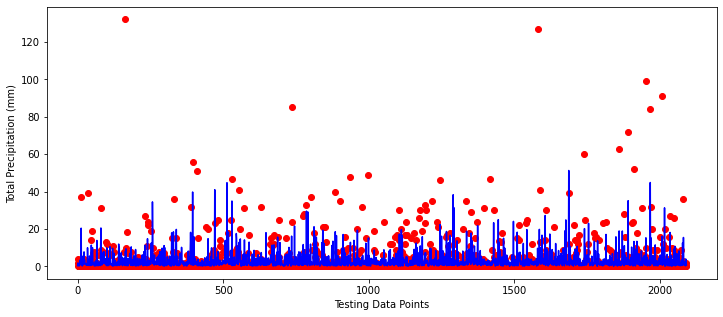

In [69]:
# Do the plot
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(test_labels, 'ro')
ax.plot(predictions, 'b-')
ax.set_xlabel('Testing Data Points')
ax.set_ylabel('Total Precipitation (mm)')
plt.show()